<br>
<font size=6>Linear Model</font>
<br>
<br>
<br>
Линейная, LASSO, Ridge регрессии и их оптимизация.<br><br>

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error

<br>
<font size=6>Эпизод Ⅰ</font><br>
<br>
<font size=5>Linear Regression</font>
<hr>
Возьмем датасет <a href='https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot'>Melbourne Housing Snapshot</a> и будем предсказывать цены на жилье.<br>
<br>
Линейные методы предполагают, что между признаками объекта (features) и целевой переменной (target/label) существует линейная зависимость, то есть
$$y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b, $$ где $у$ --- целевая переменная (что мы хотим предсказать), $x_i$ --- признак объекта $х$, $w_i$ --- вес $i$-го признака, $b$ --- bias (смещение, свободный член)

Часто предполагают, что объект $х$ содержит в себе фиктивный признак равный 1 для представления свободного члена $b$. В этом случае формула принимает простой вид:
$$y = \langle w, x \rangle,$$
где $\langle \cdot, \cdot \rangle$ -- скалярное произведение векторов $w, x \in \mathbb{R}^n$.

В матричной форме, в случае, когда у нас есть $m$ объектов формулу можно переписать следующим образом:
$$ Y = Xw, $$ где $Y$ -- столбец размера $n$, $X$ --- матрица признаков размера $n \times k$ (каждая строка матрицы есть описание признаков объекта), $w$ -- вектор весов размера $k$.

Обучение модели - это подбор весов $w$. Чтобы подобрать наилучшие веса, в моделях устанавливают <b>функцию ошибки Loss</b>.<br>
В линейной модели используют метод наименьших квадратов, который позволяется минимизировать ошибку в предсказания, подбирая новые и новые веса.<br>
<br>
Лосс: 
$$
\begin{aligned}
L(y_{pred}, Y) &= \frac{1}{n}y_{pred} - Y^2_2 =\\
&= \frac{1}{n}Xw - Y^2_2 = \frac{1}{n}\sum_{i=1}^{n}\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 =: L(w)
\end{aligned}
$$
<br>
<br>
Минимизация ошибки по методу наименьших квадратов дает решение: $$ w = (X^TX)^{-1}X^TY $$

Реализуем класс линейной регрессии с помощью этой формулы
<br>

In [2]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        
    def fit(self, X, y):
        n, k = X.shape
        
        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
        
        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y
        
        return self
    
    def predict(self, X):
        n, k = X.shape
        
        X_pred = X
        if self.fit_intercept:
            X_pred = np.hstack((X, np.ones((n, 1))))
            
        y_pred = X_pred @ self.w
        
        return y_pred
    
    def get_weights(self):
        return self.w
            

<br>
<font size=4><b>Test</b></font><br>
<br>
Сгенерируем искусственные данные для теста модели

In [3]:
def linear_expression(x):
    return 5 * x + 6

In [4]:
# по признакам сгенерируем значения таргетов с некоторым шумом
objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

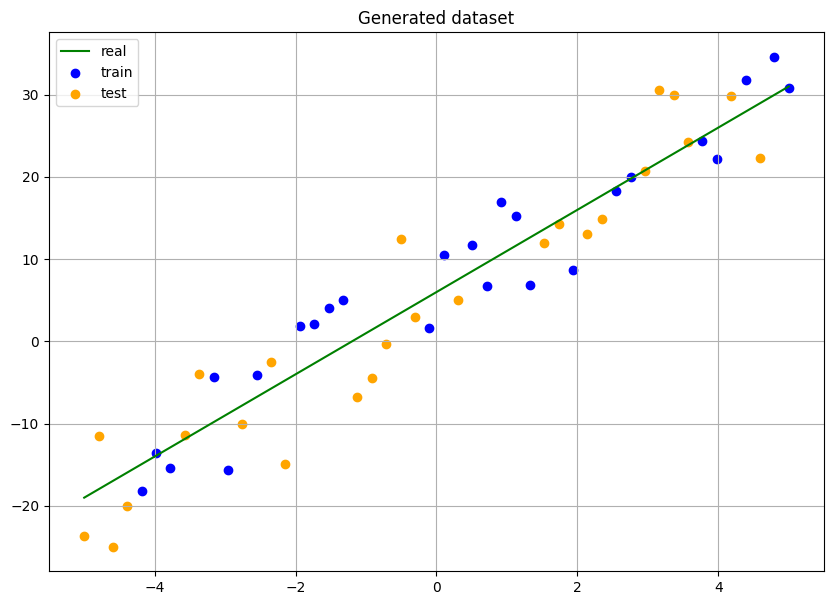

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title('Generated dataset')
plt.grid(alpha=1)
plt.legend()
plt.show()

<br>
<font size=4><b>Обучим модель трейне</b></font><br>
<br>

In [6]:
regressor = MyLinearRegression(fit_intercept=True)

regressor.fit(X_train[:, np.newaxis], y_train)
predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()
print(f'MAE = {mean_absolute_error(y_test, predictions)}')
print(f'weights = {w}')

MAE = 4.660720902930625
weights = [4.93836446 6.78169912]


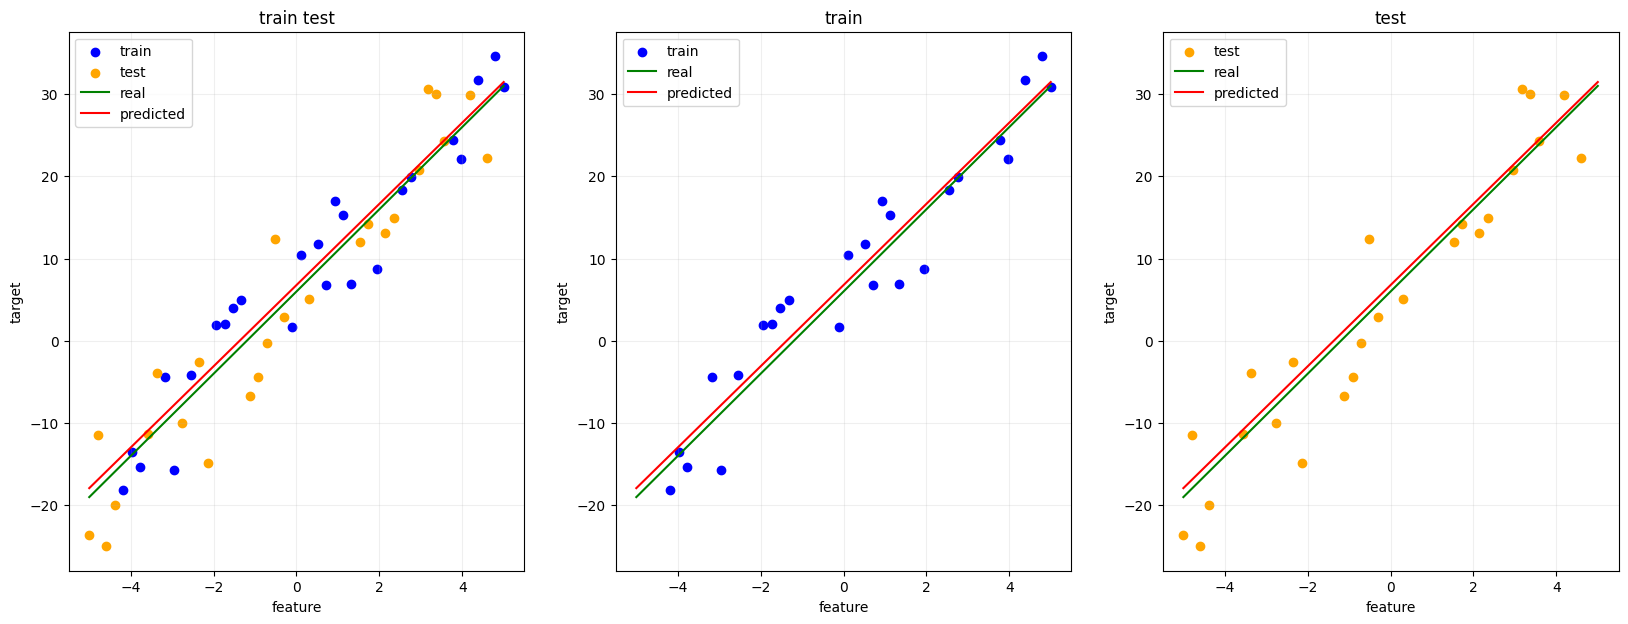

In [7]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

### 1.2. Градиентная оптимизация

Обращение матрицы -- очень долгая операция. Кроме того, обратная матрица $(X^TX)^{-1}$ не всегда существует. По этим причинам, мы воспользуемся методом градиентного спуска для оптимизации эмпирического риска.

Градиентый спуск заключается в 
1. расчете $\displaystyle\frac{\partial{L}}{\partial{w}}$ -- градиента ошибки (значение целевой функции, то есть лосса $L(y_{pred}, y_{true})$) от значения параметров модели (весов $w$)
2. шаге спуска -- изменении весов $w$ в сторону антиградиента с некоторым коэффициентом $h$ (он же learning rate):
$$w := w - h\frac{\partial{L}}{\partial{w}}$$
3. Повторении п.1 и п.2 пока не наблюдается сходимость (изменения ошибки малы или отсутсвуют)

Как правило, чаще используют стохастический градиентный спуск (SGD): выбирают случайный элемент обучающей выборки и изменяют коэффициенты модели по направлению антиградиента функции потерь на этом примере.

Цель: Реализуем новые классы линейной регрессии, в которой оптимизация проводится методами градиентного спуска.

Предполагаемая зависимость: $Y = Xw$, где $Y \in \mathbb{R}^{n\times 1}, X \in \mathbb{R}^{n\times m}, w \in \mathbb{R}^{m\times 1}$


Минимизируемая функция:
$$
L(y_{pred}, Y) = \frac{1}{n} y_{pred} - Y^2 = \frac{1}{n}Xw - Y^2 = \frac{1}{n}(Xw - Y)^T(Xw - Y) = \frac{1}{n}(w^TX^TXw - 2Y^TXw + Y^TY)
$$

Градиент w.r.t. $w$:
$$
\frac{\partial{L}}{\partial{w}} = \frac{2}{n}(X^TXw - X^TY) = \frac{2}{n}X^T(y_{pred} - Y) \,\, \in \mathbb{R}^{m \times 1}
$$

In [8]:
class MyGradientLinearRegression(MyLinearRegression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        
    def fit(self, X, y, lr=0.01, max_iter=100):
        n, k = X.shape
        if self.w is None:
            self.w = np.random.randn(k+1 if self.fit_intercept else k)
        X_train = np.hstack((X, np.ones((n, k)))) if self.fit_intercept else X
        self.losses = []
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y_pred, y))
            grad = self._calc_gradient(X_train, y, y_pred)
            assert grad.shape == self.w.shape, f'gradient shape {grad.shape} is not equal weight shape {self.w.shape}'
            self.w -= lr * grad
        return self
    
    def _calc_gradient(self, X, y, y_pred):
        grad = 2 * (y_pred - y)[:, np.newaxis] * X
        grad = grad.mean(axis=0)
        return grad
    
    def get_losses(self):
        return self.losses

In [9]:
%%time
model = MyGradientLinearRegression()
model.fit(X_train[:, np.newaxis], y_train, max_iter=100)
loss = model.get_losses()
w = model.get_weights()
predict = model.predict(X_test[:, np.newaxis])
mean_absolute_error(predict, y_test)

CPU times: user 27.9 ms, sys: 3.66 ms, total: 31.6 ms
Wall time: 31.8 ms


4.331470230580312

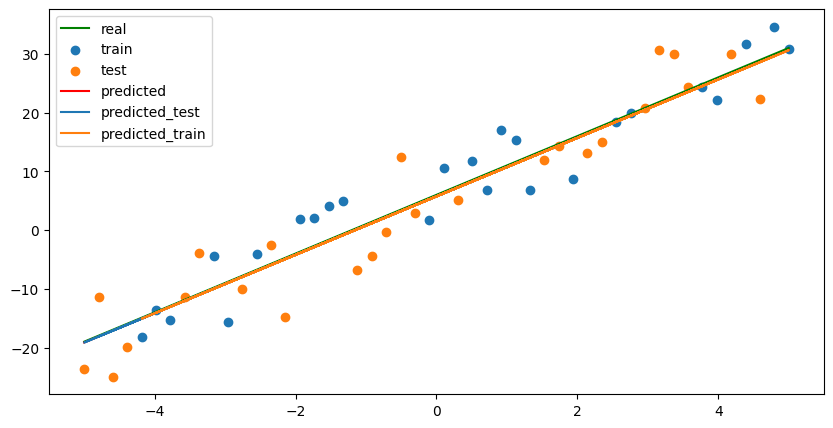

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, model.predict(X[:, np.newaxis]), label='predicted', c='r')
plt.plot(X_test, model.predict(X_test[:, np.newaxis]), label='predicted_test')
plt.plot(X_train, model.predict(X_train[:, np.newaxis]), label='predicted_train')
plt.legend()
plt.show()

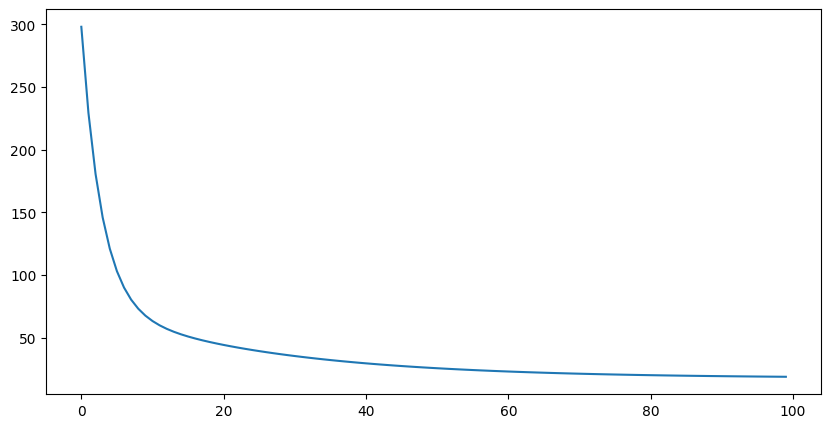

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(loss)

<br>
<font size='6'>SGD</font>
<br>
<br>

In [12]:
class MySGDLinearRegression(MyGradientLinearRegression):
    def __init__(self, n_samples=10, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.n_samples = n_samples
        
    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_samples, replace=False)
        grad = 2 * (y_pred[inds] - y[inds])[:, np.newaxis] * X[inds]
        grad = grad.mean(axis=0)
        return grad

In [13]:
model = MySGDLinearRegression()
model.fit(X_train[:, np.newaxis], y_train)
predict = model.predict(X_test[:, np.newaxis])
loss = model.get_losses()
weight = model.get_weights()
weight

array([4.93654742, 6.08658364])

In [14]:
mean_absolute_error(predict, y_test)

4.419937452705364

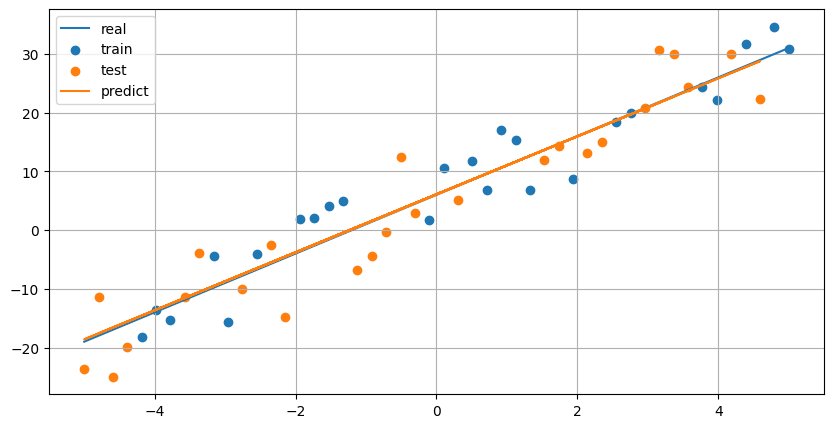

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(X, linear_expression(X), label='real')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')

plt.plot(X_test, predict, label='predict')

plt.grid()
plt.legend()
plt.show()

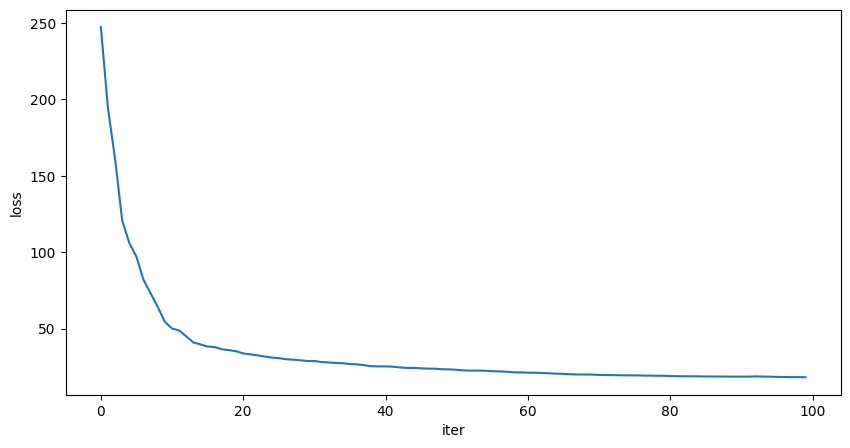

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(loss)
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

<br>
<font size='6'>Logistic Regression</font>
<br>
<br>
<b>Логистическая регрессия</b> или <b>логит-модель</b> (англ. logit model) — статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой. Эта регрессия выдаёт ответ в виде вероятности бинарного события (1 или 0).<br><br>
<b>Logistic Regression</b> относится к моделям классификации, например, разделение пользователей на интересы. То есть у нас есть классы-интересны: игры, наука, книги. Наша задача классифицировать(разбивать на классы) пользователей. <br>
Logistic Regression - та же линейная регрессия, только выходные числа переводятся в вероятности. Переход из обычного значения в вероятность происходит засчет нелинейной функции sigmoid.
Из этого следует, что диапазон логистической регрессии - [0;1].
<br><br><br>
$$\displaystyle\sigma(x) = \frac{1}{1 + e^{-x}}$$
<br>
<br>
<img src='../data/Logistic-curve.png'>
<br>
<br>
<b>Сигмоида</b> стремится к 1, когда её аргумент стремится к +бесконечности, и стремится к 0, когда её аргумент стремится к -бесконечности.<br>
<br>
<br>
<br>
Теперь <i>наша задача</i> будет состоять в предсказании класса, на основе функции <b>сигмоиды</b>:<br>
<br>
$
y_{pred}(x, w) = \frac{1}{1 + e^{-\langle x, w \rangle}}
$
<br>
<br>
<br>
Функция потерь для <i>линейной регресси</i> представляет собой <b>квадрат потери</b>.<br>
Функция потерь для <i>логистической регресии</i> - <b>Log Loss</b>:<br>
<br>
$
L(w) = -y\, log\,y_{pred} - (1-y)\,log\,(1-y_{pred})
$
<br>
<br>
<br>
Производная функции для расчета градиента:<br>
<br>
<img src='../data/grad-log.jpg' height=20 width=900>
<br>
<br>

In [17]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

class MyLogisticRegression():
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.w = None
        
    def fit(self, X, y, max_iter=100, lr=0.1):
        n, k = X.shape
        if self.w is None:
            self.w = np.random.randn(k+1)
        X_train = np.concatenate((X, np.ones((n, 1))), axis=1) if self.fit_intercept else X
        self.losses = []
        for iter_num in range(max_iter):
            y_pred = sigmoid(logit(X_train, self.w))
            grad = np.dot((y_pred-y), X_train) / len(y)
            self.w -= grad * lr
            self.losses.append(self.__loss(y, y_pred))
        return self
    
    def predict_proba(self, X):
        # Принимает на вход X и возвращает ответы модели
        n, k = X.shape
        X_test = np.concatenate((X, np.ones((n, 1))), axis=1) if self.fit_intercept else X
        return sigmoid(logit(X_test, self.w))
    
    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w
    
    def get_losses(self):
        return self.losses
    
    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

In [18]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2, 0.5], [2, -0.5]], cluster_std=1, random_state=42)

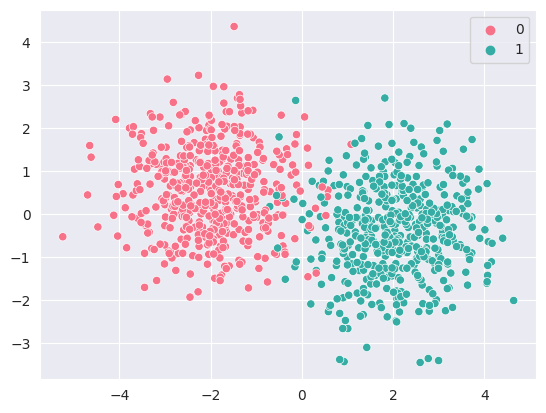

In [19]:
import seaborn as sns

sns.set_style('darkgrid')
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='husl')
plt.show()

In [20]:
clf = MyLogisticRegression()
clf.fit(X, y, max_iter=100)
w = clf.get_weights()
w

array([ 1.74146473, -0.72643483,  0.44791631])

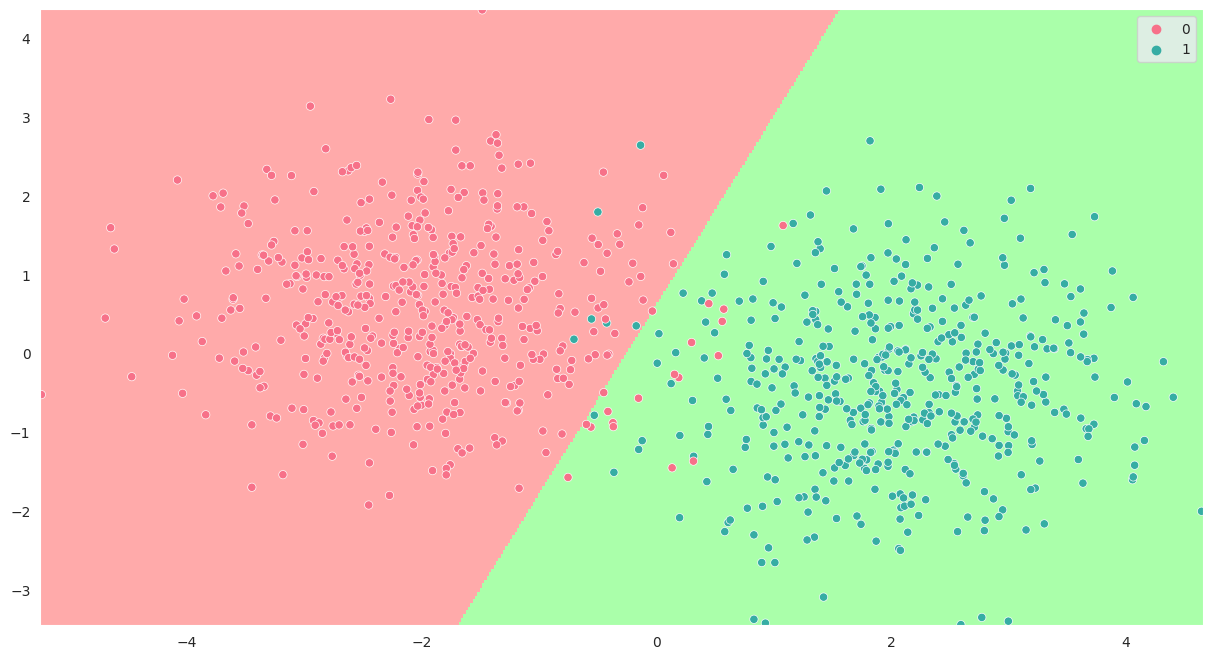

In [21]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(15, 8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 500),
                     np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 500))
z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, z, cmap=cmap_light)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='husl')
plt.show()

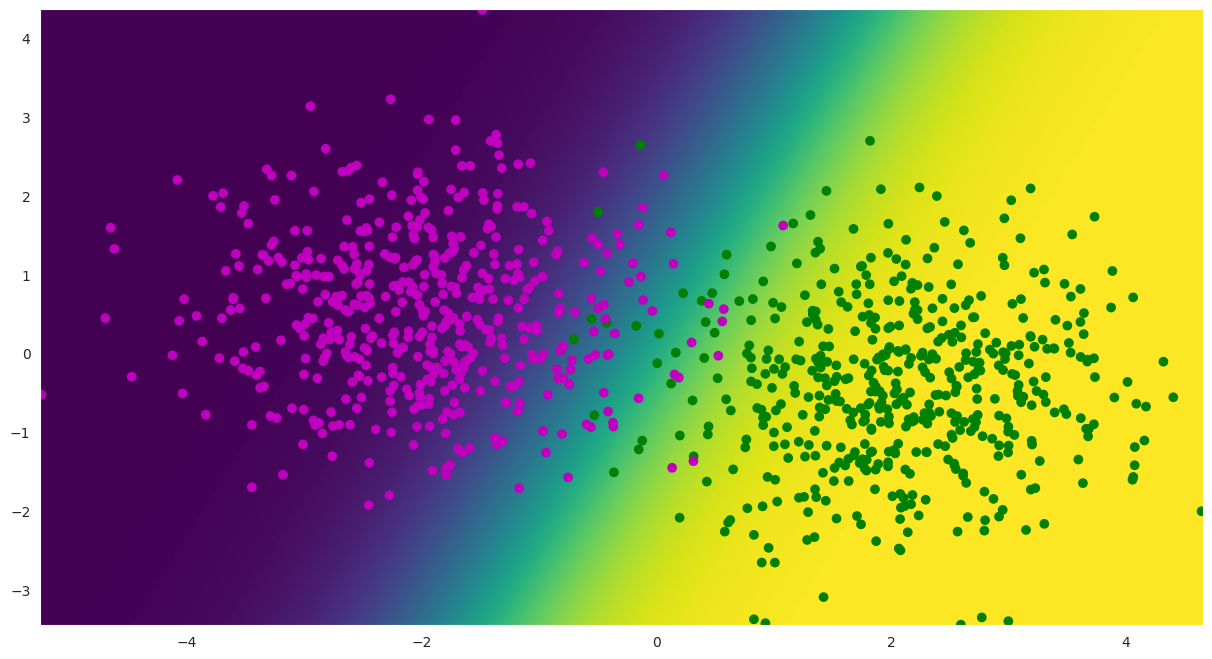

In [22]:
colors = ('magenta', 'green')
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0, 1]):
    colored_y[y == cl] = str(colors[i])
    
plt.figure(figsize=(15, 8))
z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

Z = z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

<br>
<font size='6'>Regularization</font>
<br>
<br>
<b>Регуляризация</b> в статистике, машинном обучении — метод добавления некоторых дополнительных ограничений к условию с целью решить некорректно поставленную задачу или предотвратить переобучение. Эта информация часто имеет вид штрафа за сложность модели. Например, это могут быть ограничения гладкости результирующей функции или ограничения по норме векторного пространства.
<br>
<br>

In [23]:
objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

<br>
Ridge regression (l2 regularization)
<hr>
<br>
<br>
В ridge мы штрафуем модель также на сумму квадратов всех ее весов, таким образом:

Лосс: $L(w) = Xw - Y^2_2 + \lambda||w||^2_2$, где $\lambda$ - гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

Лосс: $L(w) = \sum_{i=1}^n\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{m}w_j^2$

Что стоит сказать про значения признаков? Они должны быть стандартизованы для одинаковых штрафов относительно друг друга! (используется связка с `sklearn.preprocessing.StandardScaler`)

<br>
Аналитическое решение

Из курса статистики известно если: 
$$ L(w) = Xw - Y^2_2 + \Gamma w^2_2 $$

минимизируется при:

$$ w = (X^TX + \Gamma^T \Gamma)^{-1}X^TY $$

В нашем случае $\Gamma^T\Gamma = \lambda I$, если нет свободного члена, иначе:
$\Gamma^T\Gamma =
\left(\begin{matrix}
\lambda I & 0 \\
0 & 0
\end{matrix}\right)$

In [24]:
class MyRidgeRegression(MyLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        
    def fit(self, X, y):
        X_train = X[:, np.newaxis]
        n, m = X_train.shape
        
        if self.fit_intercept:
            X_train = np.concatenate((X_train, np.ones((n, 1))), axis=1)

        lambdaI = self.alpha * np.eye(X_train.shape[1])
        if self.fit_intercept:
            lambdaI[-1, -1] = 0
            
        self.w = np.linalg.inv(X_train.T @ X_train + lambdaI) @ X_train.T @ y
        
        return self
    
    def get_weights(self):
        return self.w

In [25]:
alpha = 1.0
regressor = MyRidgeRegression(alpha=alpha).fit(X_train, y_train)

In [26]:
from sklearn.linear_model import Ridge

sklearn_reg = Ridge(alpha).fit(X_train[:, np.newaxis], y_train)
assert np.allclose(regressor.get_weights(), np.append(sklearn_reg.coef_, sklearn_reg.intercept_))
regressor.get_weights()

array([4.80671559, 5.26017402])

<br>
SGD
<hr>

In [27]:
class MySGDRidge(MySGDLinearRegression):
    def init(self, alpha=1.0, **kwargs):
        super().init(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD - это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        lambdaI = self.alpha * np.eye(self.w.shape[0])
        if self.fit_intercept:
            lambdaI[-1, -1] = 0

        grad = 2 * (X[inds].T @ X[inds] / self.n_sample + lambdaI) @ self.w
        grad -= 2 * X[inds].T @ y[inds] / self.n_sample

        return grad

<br>
LASSO regression (l1 regularization)
<hr>
<br>
<br>

In [32]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns

In [33]:
iris = load_iris()

In [40]:
data = pd.DataFrame(data=np.hstack([iris.data, iris.target[:, np.newaxis]]),
                    columns=iris.feature_names + ['target'])
names = data.columns
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


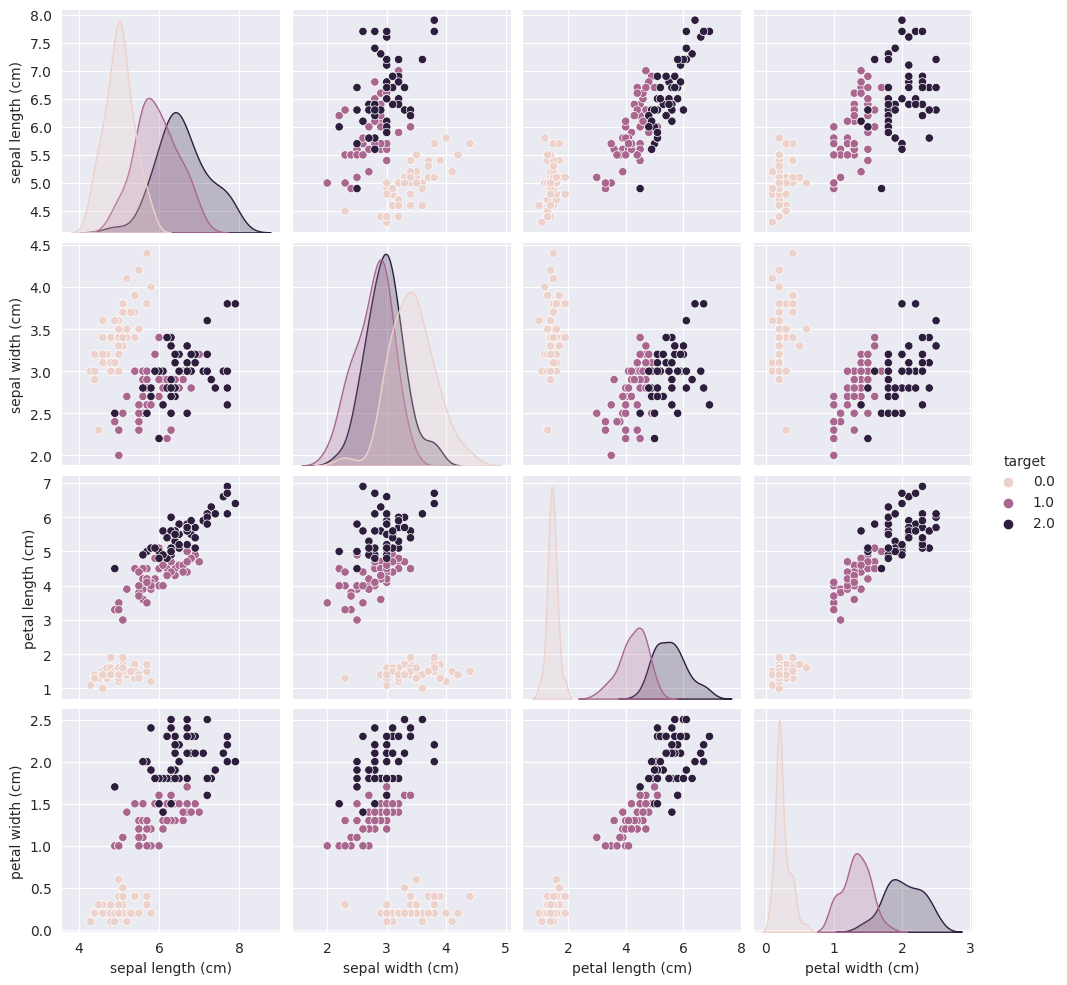

In [43]:
sns.pairplot(data, hue='target')

plt.show()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(data[names[:-1]], data[names[-1]])

In [72]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score

In [73]:
scaler = StandardScaler()
scaler_data1 = scaler.fit_transform(X_train)
scaler_data2 = scaler.transform(X_test)
claler_X_train = pd.DataFrame(data=scaler_data1, columns=names[:-1])
claler_X_test = pd.DataFrame(data=scaler_data2, columns=names[:-1])

In [102]:
log_model = LogisticRegression(C=2)
log_model.fit(X_train, y_train)

/home/yunost/Desktop/github/data-analysis-handbook/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=2)

<br>
Точность на train
<br>
<br>

In [109]:
predict = log_model.predict(X_train)
accuracy_train, fscore_train = accuracy_score(predict, y_train), f1_score(predict, y_train, average='macro')
accuracy_train, fscore_train

(0.9910714285714286, 0.9909761599902445)

<br>
Точность на test
<br>
<br>

In [110]:
predict = log_model.predict(X_test)
accuracy_test, fscore_test = accuracy_score(predict, y_test), f1_score(predict, y_test, average='macro')
accuracy_test, fscore_test

(0.9736842105263158, 0.9743209876543211)

/home/yunost/Desktop/github/data-analysis-handbook/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


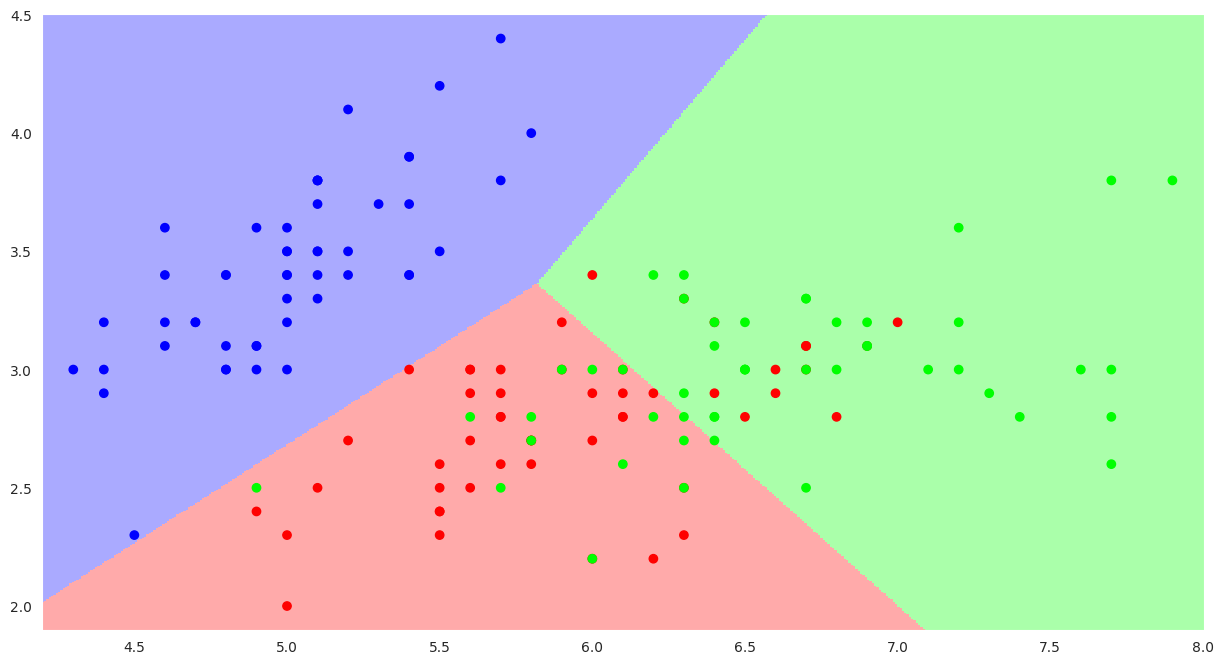

In [157]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15, 8))
eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X_train[names[0]]) - eps, np.max(X_train[names[0]]) + eps, 500),
                     np.linspace(np.min(X_train[names[1]]) - eps, np.max(X_train[names[1]]) + eps, 500))
log_model.fit(X_train[names[:2]], y_train)
z = log_model.predict(np.c_[xx.ravel(), yy.ravel()])

z = z.reshape(xx.shape)

cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, z, cmap=cmap_light)
plt.scatter(X_train[names[0]], X_train[names[1]], c=y_train, cmap='brg')
plt.scatter(X_test[names[0]], X_test[names[1]], c=y_test, cmap='brg')

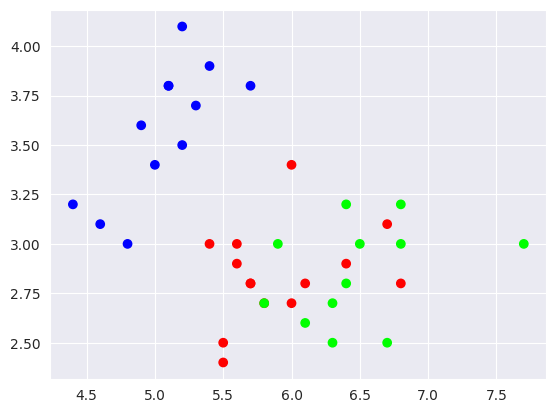

In [154]:
plt.scatter(X_test[names[0]], X_test[names[1]], c=y_test, cmap='brg')

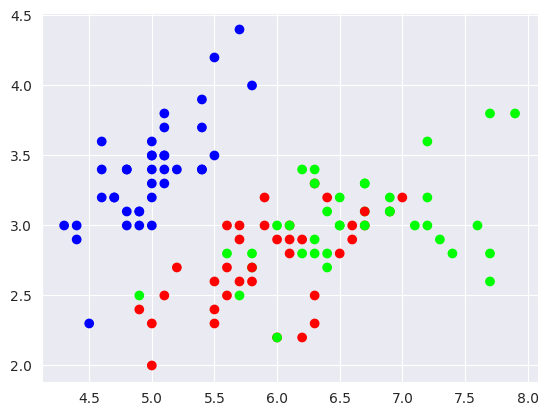

In [155]:
plt.scatter(X_train[names[0]], X_train[names[1]], c=y_train, cmap='brg')

<br>
Домашка
<br>
<br>

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [2]:
def f(x):
    """
    :param x: np.array(np.float) вектор длины 2
    :return: np.float
    """
    return np.sum(np.sin(x)**2)

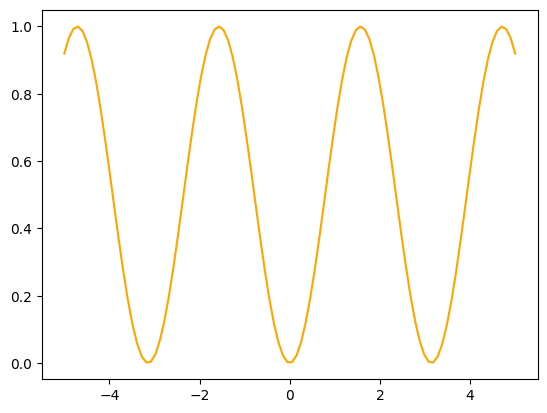

In [14]:
x = np.linspace(-5, 5, 100)
y = map(f, x)
y = np.array(list(y))
plt.plot(x, y, c='orange')
plt.show()

In [32]:
def grad_f(x):
    return 2*np.cos(x)*np.sin(x)

In [33]:
assert np.allclose(grad_f(np.array([1, 2])),
                   np.array([0.90929743, -0.7568025])), 'Что-то не так!'

In [212]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    функция, которая реализует градиентный спуск в минимум для функции f от двух переменных.
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f
        :param lr: learning rate алгоритма
        :param num_iter: кол-во итераций градиентного спуска
        :return np.array[num_iter, 2] пар вида (x, f(x))
    """
    if x0 is None:
        x0 = np.random.random(2)
    history = []
    curr_x = x0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_x, f(curr_x)))
        history.append(entry)
        curr_x -= lr * grad_f(curr_x)
        
    return np.vstack(history)

In [213]:
steps = grad_descent_2d(f, grad_f, lr=0.1, num_iter=20)

/tmp/ipykernel_1570/3868789272.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


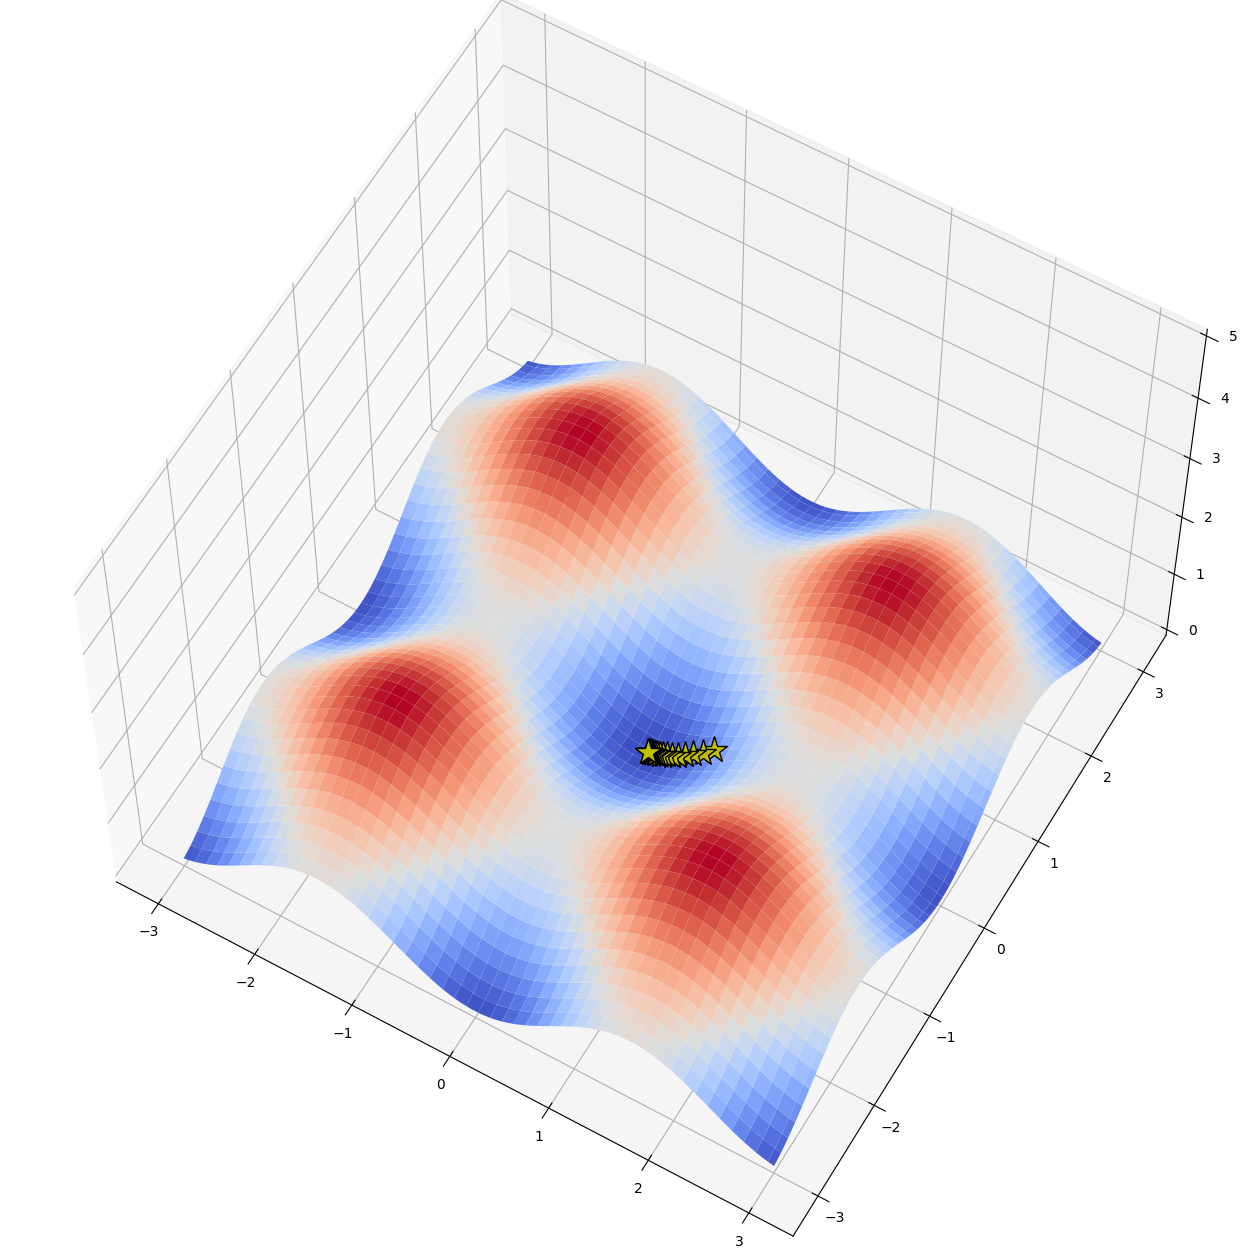

In [214]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


path = []
X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

fig = plt.figure(figsize=(16, 20))
ax = fig.gca(projection='3d')

zs = np.array([f(np.array([x, y]))
              for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2], marker='*', markersize=20, zorder=3, markerfacecolor='y', lw=3, c='black')

ax.set_zlim(0, 5)
ax.view_init(elev=60)
plt.show()

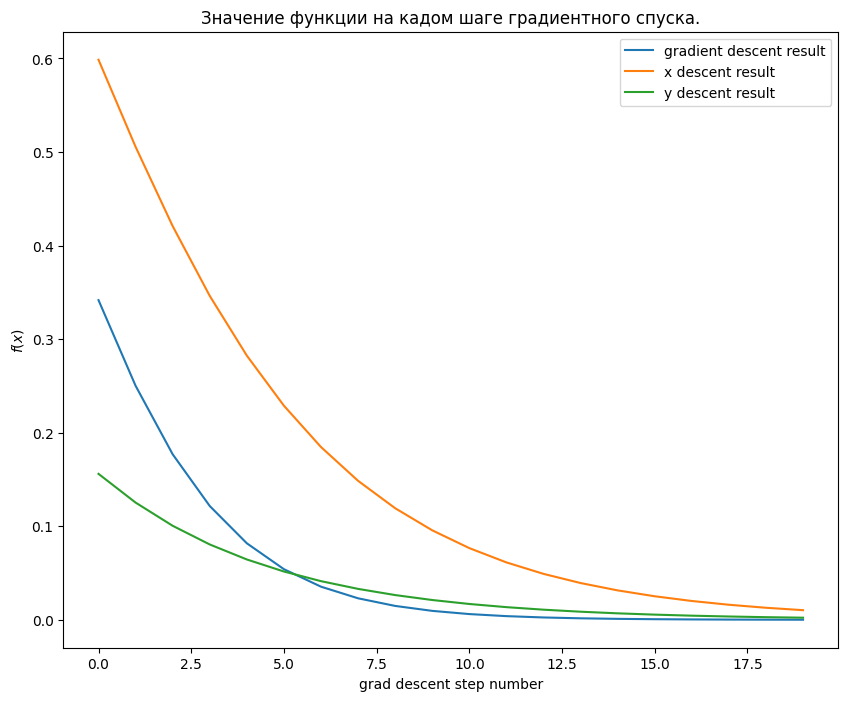

In [215]:
plt.figure(figsize=(10, 8))
plt.xlabel('grad descent step number')
plt.ylabel('$f(x)$')
plt.title('Значение функции на кадом шаге градиентного спуска.')

f_values = list(map(lambda x: x[2], steps))
x_values = list(map(lambda x: x[0], steps))
y_values = list(map(lambda x: x[1], steps))
plt.plot(f_values, label='gradient descent result')
plt.plot(x_values, label='x descent result')
plt.plot(y_values, label='y descent result')
plt.legend()
plt.show()

<br>
Генератор батчей
<br>
<br>

In [232]:
def generate_batches(X, y, batch_size):
    """
    param X: np.array[n_objects, n_features] -- матрица объект-признаки
    param y: np.array[n_objects] -- вектор целевых переменных
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))
    
    for batch_start in range(len(perm)//batch_size):
        value = perm[:batch_size]
        perm = perm[batch_size:]
        yield X[value], y[value]

In [233]:
batch = generate_batches(np.array([1, 2, 3, 4, 5, 6]), np.array([7, 8, 9, 10, 11, 12]), batch_size=2)
next(batch)

(array([1, 2]), array([7, 8]))

In [240]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

X_reconstructed, y_reconstructed = [], []
for X_batch, y_batch in generate_batches(X_fake, y_fake, 10):
    X_reconstructed.append(X_batch)
    y_reconstructed.append(y_batch)
    
X_reconstructed = np.concatenate(X_reconstructed)
y_reconstructed = np.concatenate(y_reconstructed)

assert (X_fake != X_reconstructed).all(), 'Что-то не так!'